# 2kr Analysis

In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product, chain, combinations
from scipy import stats
from IPython.display import display, HTML
%matplotlib inline

def parse_if_number(s):
    try: return float(s)
    except: return True if s=="true" else False if s=="false" else s if s else None

def parse_ndarray(s):
    return np.fromstring(s, sep=' ') if s else None

def get_file_name(name):
    return name.replace(':', '-')

## Config

In [2]:
inputFile = 'calibration.csv'
repetitionsCount = -1 # -1 = auto-detect
factors = ['R', 'T', 'm', 'D']

tIntervalAlpha = 0.95

plotSize = (10, 10)
plotStyle = 'seaborn-whitegrid'
plotErrorBars = False
saveFigures = False

# Filter scalars
scalarsFilter = ['Floorplan.userCount', 'Floorplan.coveredUsers:sum', 'Floorplan.collisions:sum']
# Filter vectors
vectorsFilter = ['Floorplan.coveredUsers:vector']
# Percentiles
percentiles = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95]

# Performance indexes
perfIndexes = [
    ('coveredUsersPercent', 'percentage of covered users'),
    ('Floorplan.collisions:sum', 'total number of collisions'),
]
intPercentiles = [int(i*100) for i in percentiles]
vecPerfIndexes = []
for intPercentile in intPercentiles:
    vecPerfIndexes.append(('broadcastTime' + str(intPercentile), 'Broadcast time needed to reach the ' + str(intPercentile) + 'th percentile of the coverage'))
for v in vecPerfIndexes:
    perfIndexes.append(v)

## Load scalars

In [3]:
df = pd.read_csv('exported_data/' + inputFile, converters = {
    'attrvalue': parse_if_number,
    'binedges': parse_ndarray,
    'binvalues': parse_ndarray,
    'vectime': parse_ndarray,
    'vecvalue': parse_ndarray,
})

In [4]:
if repetitionsCount <= 0: # auto-detect
    repetitionsCount = int(df[df.attrname == 'repetition']['attrvalue'].max()) + 1
print('Repetitions:', repetitionsCount)

# Computed
factorsCount = len(factors)
configsCount = 2**factorsCount
totalSims = configsCount*repetitionsCount

combinedFactors = list(chain(*[list(map(''.join, combinations(''.join(factors), i))) for i in range(1, factorsCount+1)]))
freedomDegrees = configsCount*(repetitionsCount - 1)


display(HTML("<style>div.output_scroll { height: auto; max-height: 48em; }</style>"))
pd.set_option('display.max_rows', totalSims)
pd.set_option('display.max_columns', 2*configsCount*repetitionsCount+1)
if saveFigures:
    os.makedirs('figures', exist_ok=True)

Repetitions: 10


In [5]:
scalars = df[(df.type == 'scalar') | ((df.type == 'itervar') & (df.attrname != 'TO')) | ((df.type == 'param') & (df.attrname == 'Floorplan.userCount')) | ((df.type == 'runattr') & (df.attrname == 'repetition'))]
scalars = scalars.assign(qname = scalars.attrname.combine_first(scalars.module + '.' + scalars.name))
for index, row in scalars[scalars.type == 'itervar'].iterrows():
    val = scalars.loc[index, 'attrvalue']
    if isinstance(val, str)  and not all(c.isdigit() for c in val):
        scalars.loc[index, 'attrvalue'] = eval(val)
scalars.value = scalars.value.combine_first(scalars.attrvalue.astype('float64'))
scalars_wide = scalars.pivot_table(index=['run'], columns='qname', values='value')
scalars_wide.sort_values([*factors, 'repetition'], inplace=True)
count = 0
for index in scalars_wide.index:
    config = count // repetitionsCount
    scalars_wide.loc[index, 'config'] = config
    count += 1
scalars_wide = scalars_wide[['config', 'repetition', *factors, *scalarsFilter]]

# coverage
scalars_wide['coveredUsersPercent'] = scalars_wide['Floorplan.coveredUsers:sum'] / (scalars_wide['Floorplan.userCount'] - 1)

## Load vectors

In [6]:
vectors = df[df.type == 'vector']
vectors = vectors.assign(qname = vectors.module + '.' + vectors.name)
for index in scalars_wide.index:
    r = index
    cfg = scalars_wide.loc[index, 'config']
    rep = scalars_wide.loc[index, 'repetition']
    vectors.loc[vectors.run == r, 'config'] = cfg
    vectors.loc[vectors.run == r, 'repetition'] = rep
vectors = vectors[vectors.qname.isin(vectorsFilter)]
vectors.sort_values(['config', 'repetition', 'qname'], inplace=True)
vectors = vectors[['config', 'repetition', 'qname', 'vectime', 'vecvalue']]

## Compute scalars from vectors

In [7]:
def get_percentile(percentile, vectime, vecvalue, totalvalue):
    tofind = percentile * totalvalue
    idx = 0
    csum = vecvalue.cumsum()
    for value in csum:
        if value >= tofind:
            return vectime[idx]
        idx += 1
    return math.inf

for index, row in vectors.iterrows():
    for vecPerf, percentile in zip(vecPerfIndexes, percentiles):
        vecPerfIndex = vecPerf[0]
        cfg = row['config']
        rep = row['repetition']
        if vecPerfIndex.startswith('broadcastTime'):
            total = scalars_wide[(scalars_wide['config'] == cfg) & (scalars_wide['repetition'] == rep)]['Floorplan.userCount'].values[0] - 1
        else:
            raise Exception('Need to specify total for ' + vecPerfIndex + '. (coding required)')
        value = get_percentile(percentile, row['vectime'], row['vecvalue'], total)
        scalars_wide.loc[(scalars_wide['config'] == cfg) & (scalars_wide['repetition'] == rep), vecPerfIndex] = value

## 2kr

In [8]:
cols = ['exp', 'I'] + combinedFactors
data = [[e, 1] + list(chain(*[list(map(np.prod, combinations(r, i))) for i in range(1, len(r)+1)])) for r,e in zip([list(x) for x in product([-1, 1], repeat=factorsCount)], range(0, configsCount))]
factorsMatrix = pd.DataFrame.from_records(data, columns=cols, index='exp')

computeMatrices = []
ciMatrices = []
errorVariances = []
skipped = []

for perfIndex, perfIndexDesc in perfIndexes:
    print("2^k*r analysis for the", perfIndexDesc)
    cols = ['exp'] + ['y' + str(i) for i in range(0, repetitionsCount)]
    data = [[i] + scalars_wide[scalars_wide.config == i][perfIndex].values.tolist() for i in range(0, configsCount)]
    ysMatrix = pd.DataFrame.from_records(data, columns=cols, index='exp')
    ysMatrix['mean'] = ysMatrix.mean(axis=1)
    next2kr = False
    for r in range(0, repetitionsCount):
        for c in range(0, configsCount):
            if math.isinf(ysMatrix['y' + str(r)].values[c]):
                print('!!! Observations contain infinite values. Skipping...')
                print()
                skipped.append(perfIndex)
                next2kr = True
                break
        if next2kr:
            break
        ysMatrix['e' + str(r)] = ysMatrix['y' + str(r)] - ysMatrix['mean']
    if next2kr:
        continue

    matrix = pd.concat([factorsMatrix, ysMatrix], axis=1)

    computeCols = ['idx', 'I'] + combinedFactors + ['e' + str(r) for r in range(0, repetitionsCount)]
    data = [['Sum'], ['Mean (Qi)'], ['SSQ']]
    SSE = 0
    for col in computeCols[1:]:
        sumvalue = np.sum(matrix[col].values * matrix['mean'].values)
        data[0].append(sumvalue)
        data[1].append(sumvalue / configsCount)
        if col in ['e' + str(r) for r in range(0, repetitionsCount)]:
            ssq = np.sum(matrix[col].values * matrix[col].values)
            data[2].append(ssq)
            SSE += ssq
        else:
            data[2].append('')
    computeMatrix = pd.DataFrame.from_records(data, columns=computeCols, index='idx')

    data = [['(2^k)*r*(qi)^2'], ['Variation'], ['Variation%']]
    SST = SSE
    for col in combinedFactors:
        qi = computeMatrix.loc['Mean (Qi)', col]
        r2kqi2 = configsCount*repetitionsCount*(qi**2)
        data[0].append(r2kqi2)
        SST += r2kqi2
    data[0].append(SSE)
    idx = 1
    for col in combinedFactors:
        r2kqi2 = data[0][idx]
        var = r2kqi2 / SST
        data[1].append(var)
        data[2].append('{:.2%}'.format(var))
        idx += 1
    data[1].append(SST)
    data[2].append('{:.2%}'.format(SSE/SST))
    resultMatrix = pd.DataFrame.from_records(data, columns=['idx'] + combinedFactors + ['SSE/SST'], index='idx')

    errorVariance = SSE / freedomDegrees
    negativeInterval, positiveInterval = tuple(v*math.sqrt(errorVariance/(configsCount*repetitionsCount)) for v in stats.t.interval(tIntervalAlpha, freedomDegrees))
    data = [['CI+ Qi ({:.2%})'.format(tIntervalAlpha)], ['CI- Qi ({:.2%})'.format(tIntervalAlpha)], ['Distance (Qi)'], ['Zero Included'], ['CI+ Variation'], ['CI- Variation'], ['CI Distance (Variation)']]
    for col in combinedFactors:
        qi = computeMatrix.loc['Mean (Qi)', col]
        upper = qi + positiveInterval
        lower = qi + negativeInterval
        data[0].append(upper)
        data[1].append(lower)
        data[2].append(abs(upper - lower))
        data[3].append(upper >= 0 and lower <= 0)
        upper = (configsCount*repetitionsCount*(upper**2))/SST
        lower = (configsCount*repetitionsCount*(lower**2))/SST
        data[4].append(upper)
        data[5].append(lower)
        data[6].append(abs(upper - lower))
    ciMatrix = pd.DataFrame.from_records(data, columns=['idx'] + combinedFactors, index='idx')

    computeMatrices.append(computeMatrix)
    ciMatrices.append(ciMatrix)
    errorVariances.append(errorVariance)

    display(matrix)
    display(computeMatrix)
    display(resultMatrix)
    display(ciMatrix)

    print('SSE =', SSE)
    print('SST =', SST)
    print('Error variance =', errorVariance)
    print('Unexplained Variation =', '{:.2%}'.format(SSE/SST))
    print()
    print('####################################')
    print()

2^k*r analysis for the percentage of covered users


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,0.997996,1.000000,1.000000,0.995992,0.997996,1.000000,0.993988,0.997996,1.000000,0.997996,0.998196,-0.000200,0.001804,0.001804,-0.002204,-0.000200,0.001804,-0.004208,-0.000200,0.001804,-0.000200
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,1.000000,1.000000,1.000000,0.997996,1.000000,1.000000,1.000000,0.997996,1.000000,1.000000,0.999599,0.000401,0.000401,0.000401,-0.001603,0.000401,0.000401,0.000401,-0.001603,0.000401,0.000401
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,0.993988,0.995992,1.000000,1.000000,1.000000,0.993988,0.997996,0.995992,0.997996,0.997996,0.997395,-0.003407,-0.001403,0.002605,0.002605,0.002605,-0.003407,0.000601,-0.001403,0.000601,0.000601
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,1.000000,1.000000,0.997996,0.997996,1.000000,0.997996,1.000000,0.995992,0.997996,1.000000,0.998798,0.001202,0.001202,-0.000802,-0.000802,0.001202,-0.000802,0.001202,-0.002806,-0.000802,0.001202
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,1.000000,1.000000,0.993988,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999399,0.000601,0.000601,-0.005411,0.000601,0.000601,0.000601,0.000601,0.000601,0.000601,0.000601
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,1.000000,1.000000,0.997996,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.997996,0.999599,0.000401,0.000401,-0.001603,0.000401,0.000401,0.000401,0.000401,0.000401,0.000401,-0.001603
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,0.941884,0.959920,0.981964,0.915832,0.943888,0.971944,0.985972,0.945892,0.975952,0.929860,0.955311,-0.013427,0.004609,0.026653,-0.039479,-0.011423,0.016633,0.030661,-0.009419,0.020641,-0.025451


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,15.811222,-0.174749,0.120641,0.03006,0.03006,0.110621,0.032866,0.022445,-0.004409,0.01483,-0.017234,-0.008016,0.018437,-0.016834,-0.004409,-0.004008,0.023621,0.021276,0.040527,-0.134264,-0.051420,0.050619,0.011860,0.018047,0.045067,-0.025331
Mean (Qi),0.988201,-0.010922,0.00754,0.001879,0.001879,0.006914,0.002054,0.001403,-0.000276,0.000927,-0.001077,-0.000501,0.001152,-0.001052,-0.000276,-0.000251,0.001476,0.001330,0.002533,-0.008392,-0.003214,0.003164,0.000741,0.001128,0.002817,-0.001583
SSQ,,,,,,,,,,,,,,,,,0.002022,0.001294,0.001352,0.008507,0.001464,0.000732,0.001696,0.000828,0.000787,0.004083


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,0.019086,0.009096,0.000565,0.000565,0.007648,0.000675,0.000315,0.000012,0.000137,0.000186,0.00004,0.000212,0.000177,0.000012,0.00001,0.022765
Variation,0.310331,0.147906,0.009183,0.009183,0.124357,0.010977,0.00512,0.000198,0.002235,0.003018,0.000653,0.003454,0.00288,0.000198,0.000163,0.061502
Variation%,31.03%,14.79%,0.92%,0.92%,12.44%,1.10%,0.51%,0.02%,0.22%,0.30%,0.07%,0.35%,0.29%,0.02%,0.02%,37.01%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-0.008957,0.009505,0.003843,0.003843,0.008879,0.004019,0.003368,0.001689,0.002892,0.000888,0.001464,0.003117,0.000913,0.001689,0.001714
CI- Qi (95.00%),-0.012887,0.005575,-0.000086,-0.000086,0.004949,0.000089,-0.000562,-0.00224,-0.001038,-0.003042,-0.002466,-0.000812,-0.003017,-0.00224,-0.002215
Distance (Qi),0.003929,0.003929,0.003929,0.003929,0.003929,0.003929,0.003929,0.003929,0.003929,0.003929,0.003929,0.003929,0.003929,0.003929,0.003929
Zero Included,False,False,True,True,False,False,True,True,True,True,True,True,True,True,True
CI+ Variation,0.208723,0.235028,0.038431,0.038431,0.205077,0.042018,0.029502,0.007423,0.021752,0.002049,0.005574,0.025276,0.002167,0.007423,0.007645
CI- Variation,0.432024,0.080868,0.000019,0.000019,0.063722,0.000021,0.000821,0.013057,0.002802,0.024072,0.015817,0.001717,0.023677,0.013057,0.012766
CI Distance (Variation),0.223301,0.15416,0.038412,0.038412,0.141356,0.041997,0.028681,0.005634,0.01895,0.022023,0.010243,0.023559,0.021511,0.005634,0.005122


SSE = 0.022764567210573447
SST = 0.061501660635901026
Error variance = 0.00015808727229564893
Unexplained Variation = 37.01%

####################################

2^k*r analysis for the total number of collisions


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,567.0,629.0,569.0,562.0,527.0,562.0,565.0,596.0,526.0,561.0,566.4,0.6,62.6,2.6,-4.4,-39.4,-4.4,-1.4,29.6,-40.4,-5.4
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,501.0,581.0,532.0,439.0,434.0,453.0,415.0,456.0,495.0,447.0,475.3,25.7,105.7,56.7,-36.3,-41.3,-22.3,-60.3,-19.3,19.7,-28.3
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,564.0,587.0,591.0,561.0,600.0,605.0,547.0,574.0,591.0,582.0,580.2,-16.2,6.8,10.8,-19.2,19.8,24.8,-33.2,-6.2,10.8,1.8
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,461.0,564.0,433.0,499.0,498.0,483.0,448.0,521.0,416.0,499.0,482.2,-21.2,81.8,-49.2,16.8,15.8,0.8,-34.2,38.8,-66.2,16.8
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,391.0,425.0,428.0,408.0,470.0,400.0,424.0,387.0,423.0,427.0,418.3,-27.3,6.7,9.7,-10.3,51.7,-18.3,5.7,-31.3,4.7,8.7
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,299.0,330.0,306.0,291.0,331.0,328.0,339.0,298.0,304.0,270.0,309.6,-10.6,20.4,-3.6,-18.6,21.4,18.4,29.4,-11.6,-5.6,-39.6
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,443.0,481.0,493.0,458.0,411.0,442.0,417.0,468.0,438.0,459.0,451.0,-8.0,30.0,42.0,7.0,-40.0,-9.0,-34.0,17.0,-13.0,8.0
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,335.0,338.0,321.0,320.0,322.0,343.0,298.0,323.0,377.0,366.0,334.3,0.7,3.7,-13.3,-14.3,-12.3,8.7,-36.3,-11.3,42.7,31.7
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,1930.0,1908.0,1699.0,1825.0,2083.0,2199.0,1662.0,2166.0,2022.0,1882.0,1937.6,-7.6,-29.6,-238.6,-112.6,145.4,261.4,-275.6,228.4,84.4,-55.6


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,20739.9,13505.3,-1020.3,2613.1,-534.9,161.5,2456.9,294.1,1065.7,-1017.1,542.3,992.3,-944.5,572.1,240.9,243.1,-1.686660e+06,-1.527140e+06,187616.910000,-141783.290000,789769.210000,210133.510000,500808.910000,1.176771e+06,404267.810000,86215.610000
Mean (Qi),1296.24375,844.08125,-63.76875,163.31875,-33.43125,10.09375,153.55625,18.38125,66.60625,-63.56875,33.89375,62.01875,-59.03125,35.75625,15.05625,15.19375,-1.054163e+05,-9.544622e+04,11726.056875,-8861.455625,49360.575625,13133.344375,31300.556875,7.354820e+04,25266.738125,5388.475625
SSQ,,,,,,,,,,,,,,,,,4.119284e+05,1.937900e+05,348797.990000,295486.390000,522639.390000,183661.790000,263139.990000,1.599944e+05,135543.190000,58821.590000


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,113995705.05625,650632.55625,4267682.25625,178823.75625,16301.40625,3772723.50625,54059.25625,709822.80625,646557.75625,183805.80625,615412.05625,557550.15625,204561.50625,36270.50625,36936.00625,2573803.1
Variation,0.887122,0.005063,0.033211,0.001392,0.000127,0.02936,0.000421,0.005524,0.005032,0.00143,0.004789,0.004339,0.001592,0.000282,0.000287,128500647.49375
Variation%,88.71%,0.51%,3.32%,0.14%,0.01%,2.94%,0.04%,0.55%,0.50%,0.14%,0.48%,0.43%,0.16%,0.03%,0.03%,2.00%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),864.972274,-42.877726,184.209774,-12.540226,30.984774,174.447274,39.272274,87.497274,-42.677726,54.784774,82.909774,-38.140226,56.647274,35.947274,36.084774
CI- Qi (95.00%),823.190226,-84.659774,142.427726,-54.322274,-10.797274,132.665226,-2.509774,45.715226,-84.459774,13.002726,41.127726,-79.922274,14.865226,-5.834774,-5.697274
Distance (Qi),41.782049,41.782049,41.782049,41.782049,41.782049,41.782049,41.782049,41.782049,41.782049,41.782049,41.782049,41.782049,41.782049,41.782049,41.782049
Zero Included,False,False,False,False,True,False,True,False,False,False,False,False,False,True,True
CI+ Variation,0.931578,0.002289,0.042251,0.000196,0.001195,0.037892,0.00192,0.009532,0.002268,0.003737,0.008559,0.001811,0.003996,0.001609,0.001621
CI- Variation,0.843753,0.008924,0.025258,0.003674,0.000145,0.021914,0.000008,0.002602,0.008882,0.000211,0.002106,0.007953,0.000275,0.000042,0.00004
CI Distance (Variation),0.087825,0.006635,0.016993,0.003478,0.00105,0.015977,0.001913,0.00693,0.006614,0.003527,0.006453,0.006142,0.00372,0.001567,0.001581


SSE = 2573803.0999999996
SST = 128500647.49374995
Error variance = 17873.632638888885
Unexplained Variation = 2.00%

####################################

2^k*r analysis for the Broadcast time needed to reach the 10th percentile of the coverage


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,19.0,11.0,11.0,11.0,13.0,8.0,13.0,12.0,12.0,15.0,12.5,6.5,-1.5,-1.5,-1.5,0.5,-4.5,0.5,-0.5,-0.5,2.5
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,13.0,16.0,13.0,18.0,11.0,12.0,12.0,15.0,11.0,10.0,13.1,-0.1,2.9,-0.1,4.9,-2.1,-1.1,-1.1,1.9,-2.1,-3.1
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,11.0,18.0,12.0,12.0,13.0,11.0,11.0,13.0,8.0,11.0,12.0,-1.0,6.0,0.0,0.0,1.0,-1.0,-1.0,1.0,-4.0,-1.0
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,12.0,10.0,15.0,14.0,19.0,29.0,11.0,17.0,12.0,13.0,15.2,-3.2,-5.2,-0.2,-1.2,3.8,13.8,-4.2,1.8,-3.2,-2.2
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,20.0,37.0,19.0,32.0,33.0,13.0,26.0,22.0,23.0,23.0,24.8,-4.8,12.2,-5.8,7.2,8.2,-11.8,1.2,-2.8,-1.8,-1.8
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,21.0,22.0,38.0,24.0,24.0,16.0,30.0,26.0,20.0,29.0,25.0,-4.0,-3.0,13.0,-1.0,-1.0,-9.0,5.0,1.0,-5.0,4.0
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,24.0,22.0,21.0,25.0,22.0,14.0,19.0,20.0,32.0,21.0,22.0,2.0,0.0,-1.0,3.0,0.0,-8.0,-3.0,-2.0,10.0,-1.0
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,15.0,20.0,22.0,22.0,22.0,12.0,21.0,23.0,22.0,23.0,20.2,-5.2,-0.2,1.8,1.8,1.8,-8.2,0.8,2.8,1.8,2.8
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,1.0,1.0,1.0,1.0,1.0,7.0,1.0,6.0,1.0,1.0,2.1,-1.1,-1.1,-1.1,-1.1,-1.1,4.9,-1.1,3.9,-1.1,-1.1


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,161.8,-127.8,43.0,-7.6,3.4,-35.4,4.4,-1.0,-9.6,-5.0,-0.4,8.8,5.8,-1.6,-8.8,0.4,-251.280,211.920,183.82000,304.5200,249.42000,-743.38000,30.42000,12.82000,-17.0800,18.82000
Mean (Qi),10.1125,-7.9875,2.6875,-0.475,0.2125,-2.2125,0.275,-0.0625,-0.6,-0.3125,-0.025,0.55,0.3625,-0.1,-0.55,0.025,-15.705,13.245,11.48875,19.0325,15.58875,-46.46125,1.90125,0.80125,-1.0675,1.17625
SSQ,,,,,,,,,,,,,,,,,170.780,246.380,287.58000,236.1800,121.38000,601.98000,103.38000,57.58000,274.3800,84.58000


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,10208.025,1155.625,36.1,7.225,783.225,12.1,0.625,57.6,15.625,0.1,48.4,21.025,1.6,48.4,0.1,2184.2
Variation,0.70014,0.079261,0.002476,0.000496,0.053719,0.00083,0.000043,0.003951,0.001072,0.000007,0.00332,0.001442,0.00011,0.00332,0.000007,14579.975
Variation%,70.01%,7.93%,0.25%,0.05%,5.37%,0.08%,0.00%,0.40%,0.11%,0.00%,0.33%,0.14%,0.01%,0.33%,0.00%,14.98%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-7.378919,3.296081,0.133581,0.821081,-1.603919,0.883581,0.546081,0.008581,0.296081,0.583581,1.158581,0.971081,0.508581,0.058581,0.633581
CI- Qi (95.00%),-8.596081,2.078919,-1.083581,-0.396081,-2.821081,-0.333581,-0.671081,-1.208581,-0.921081,-0.633581,-0.058581,-0.246081,-0.708581,-1.158581,-0.583581
Distance (Qi),1.217162,1.217162,1.217162,1.217162,1.217162,1.217162,1.217162,1.217162,1.217162,1.217162,1.217162,1.217162,1.217162,1.217162,1.217162
Zero Included,False,False,True,True,False,True,True,True,True,True,True,True,True,True,True
CI+ Variation,0.597515,0.119223,0.000196,0.007398,0.028231,0.008568,0.003272,0.000001,0.000962,0.003737,0.01473,0.010348,0.002838,0.000038,0.004405
CI- Variation,0.810894,0.047428,0.012885,0.001722,0.087336,0.001221,0.004942,0.016029,0.00931,0.004405,0.000038,0.000665,0.00551,0.01473,0.003737
CI Distance (Variation),0.213379,0.071794,0.012689,0.005677,0.059105,0.007346,0.00167,0.016028,0.008348,0.000668,0.014693,0.009684,0.002671,0.014693,0.000668


SSE = 2184.2
SST = 14579.975
Error variance = 15.168055555555554
Unexplained Variation = 14.98%

####################################

2^k*r analysis for the Broadcast time needed to reach the 25th percentile of the coverage


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,31.0,19.0,16.0,22.0,22.0,18.0,22.0,19.0,23.0,25.0,21.7,9.3,-2.7,-5.7,0.3,0.3,-3.7,0.3,-2.7,1.3,3.3
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,25.0,28.0,25.0,36.0,22.0,24.0,24.0,27.0,20.0,19.0,25.0,0.0,3.0,0.0,11.0,-3.0,-1.0,-1.0,2.0,-5.0,-6.0
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,16.0,27.0,23.0,22.0,21.0,19.0,19.0,26.0,17.0,19.0,20.9,-4.9,6.1,2.1,1.1,0.1,-1.9,-1.9,5.1,-3.9,-1.9
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,18.0,22.0,25.0,26.0,33.0,44.0,25.0,36.0,22.0,20.0,27.1,-9.1,-5.1,-2.1,-1.1,5.9,16.9,-2.1,8.9,-5.1,-7.1
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,44.0,55.0,33.0,52.0,62.0,34.0,46.0,33.0,41.0,35.0,43.5,0.5,11.5,-10.5,8.5,18.5,-9.5,2.5,-10.5,-2.5,-8.5
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,46.0,51.0,62.0,46.0,57.0,37.0,51.0,62.0,32.0,50.0,49.4,-3.4,1.6,12.6,-3.4,7.6,-12.4,1.6,12.6,-17.4,0.6
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,53.0,43.0,31.0,44.0,40.0,33.0,31.0,40.0,53.0,34.0,40.2,12.8,2.8,-9.2,3.8,-0.2,-7.2,-9.2,-0.2,12.8,-6.2
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,30.0,41.0,38.0,35.0,35.0,28.0,34.0,59.0,38.0,39.0,37.7,-7.7,3.3,0.3,-2.7,-2.7,-9.7,-3.7,21.3,0.3,1.3
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,11.0,7.0,11.0,11.0,11.0,12.0,7.0,12.0,12.0,6.0,10.0,1.0,-3.0,1.0,1.0,1.0,2.0,-3.0,2.0,2.0,-4.0


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,347.5,-183.5,91.1,-16.1,11.1,-61.1,11.3,-14.7,-16.9,-3.7,-4.9,15.7,8.5,6.1,-17.7,4.9,-30.330000,735.170000,-293.830000,653.670000,1110.470000,-1461.530000,-332.530000,1271.170000,-692.330000,-959.930000
Mean (Qi),21.71875,-11.46875,5.69375,-1.00625,0.69375,-3.81875,0.70625,-0.91875,-1.05625,-0.23125,-0.30625,0.98125,0.53125,0.38125,-1.10625,0.30625,-1.895625,45.948125,-18.364375,40.854375,69.404375,-91.345625,-20.783125,79.448125,-43.270625,-59.995625
SSQ,,,,,,,,,,,,,,,,,530.930000,278.930000,492.930000,341.930000,481.330000,720.330000,201.330000,867.930000,594.930000,255.130000


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,21045.15625,5187.00625,162.00625,77.00625,2333.25625,79.80625,135.05625,178.50625,8.55625,15.00625,154.05625,45.15625,23.25625,195.80625,15.00625,4765.7
Variation,0.611416,0.150696,0.004707,0.002237,0.067787,0.002319,0.003924,0.005186,0.000249,0.000436,0.004476,0.001312,0.000676,0.005689,0.000436,34420.34375
Variation%,61.14%,15.07%,0.47%,0.22%,6.78%,0.23%,0.39%,0.52%,0.02%,0.04%,0.45%,0.13%,0.07%,0.57%,0.04%,13.85%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-10.5698,6.5927,-0.1073,1.5927,-2.9198,1.6052,-0.0198,-0.1573,0.6677,0.5927,1.8802,1.4302,1.2802,-0.2073,1.2052
CI- Qi (95.00%),-12.3677,4.7948,-1.9052,-0.2052,-4.7177,-0.1927,-1.8177,-1.9552,-1.1302,-1.2052,0.0823,-0.3677,-0.5177,-2.0052,-0.5927
Distance (Qi),1.7979,1.7979,1.7979,1.7979,1.7979,1.7979,1.7979,1.7979,1.7979,1.7979,1.7979,1.7979,1.7979,1.7979,1.7979
Zero Included,False,False,False,True,False,True,False,False,True,True,False,True,True,False,True
CI+ Variation,0.519324,0.202037,0.000054,0.011792,0.039629,0.011977,0.000002,0.000115,0.002072,0.001633,0.016433,0.009508,0.007618,0.0002,0.006752
CI- Variation,0.711021,0.106868,0.016873,0.000196,0.103458,0.000173,0.015359,0.01777,0.005938,0.006752,0.000031,0.000628,0.001246,0.01869,0.001633
CI Distance (Variation),0.191697,0.09517,0.016819,0.011596,0.063829,0.011805,0.015357,0.017655,0.003865,0.005119,0.016401,0.00888,0.006373,0.018491,0.005119


SSE = 4765.7
SST = 34420.34375
Error variance = 33.09513888888889
Unexplained Variation = 13.85%

####################################

2^k*r analysis for the Broadcast time needed to reach the 50th percentile of the coverage


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,47.0,34.0,27.0,31.0,34.0,34.0,36.0,34.0,34.0,38.0,34.9,12.1,-0.9,-7.9,-3.9,-0.9,-0.9,1.1,-0.9,-0.9,3.1
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,44.0,43.0,37.0,56.0,44.0,38.0,45.0,43.0,35.0,31.0,41.6,2.4,1.4,-4.6,14.4,2.4,-3.6,3.4,1.4,-6.6,-10.6
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,27.0,40.0,35.0,35.0,36.0,30.0,30.0,40.0,29.0,32.0,33.4,-6.4,6.6,1.6,1.6,2.6,-3.4,-3.4,6.6,-4.4,-1.4
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,28.0,36.0,40.0,43.0,48.0,59.0,39.0,53.0,36.0,32.0,41.4,-13.4,-5.4,-1.4,1.6,6.6,17.6,-2.4,11.6,-5.4,-9.4
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,72.0,75.0,54.0,78.0,88.0,53.0,75.0,51.0,68.0,52.0,66.6,5.4,8.4,-12.6,11.4,21.4,-13.6,8.4,-15.6,1.4,-14.6
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,73.0,87.0,87.0,75.0,86.0,58.0,76.0,96.0,55.0,76.0,76.9,-3.9,10.1,10.1,-1.9,9.1,-18.9,-0.9,19.1,-21.9,-0.9
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,84.0,70.0,47.0,73.0,63.0,54.0,60.0,67.0,88.0,55.0,66.1,17.9,3.9,-19.1,6.9,-3.1,-12.1,-6.1,0.9,21.9,-11.1
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,49.0,74.0,71.0,50.0,60.0,55.0,52.0,87.0,70.0,64.0,63.2,-14.2,10.8,7.8,-13.2,-3.2,-8.2,-11.2,23.8,6.8,0.8
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,16.0,12.0,13.0,15.0,14.0,16.0,12.0,19.0,17.0,11.0,14.5,1.5,-2.5,-1.5,0.5,-0.5,1.5,-2.5,4.5,2.5,-3.5


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,558.2,-290.0,150.0,-19.8,18.0,-93.0,12.0,-26.2,-16.8,-7.0,-11.6,8.2,7.6,12.2,-20.6,8.4,293.42000,2279.52,-1242.58000,895.3200,1863.42000,-3302.18000,-498.480,2511.7200,-195.78000,-2604.38000
Mean (Qi),34.8875,-18.125,9.375,-1.2375,1.125,-5.8125,0.75,-1.6375,-1.05,-0.4375,-0.725,0.5125,0.475,0.7625,-1.2875,0.525,18.33875,142.47,-77.66125,55.9575,116.46375,-206.38625,-31.155,156.9825,-12.23625,-162.77375
SSQ,,,,,,,,,,,,,,,,,1059.08000,417.88,827.08000,677.2800,745.08000,1110.28000,332.880,1467.4800,1174.48000,581.68000


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,52562.5,14062.5,245.025,202.5,5405.625,90.0,429.025,176.4,30.625,84.1,42.025,36.1,93.025,265.225,44.1,8393.2
Variation,0.639742,0.171156,0.002982,0.002465,0.065792,0.001095,0.005222,0.002147,0.000373,0.001024,0.000511,0.000439,0.001132,0.003228,0.000537,82161.975
Variation%,63.97%,17.12%,0.30%,0.25%,6.58%,0.11%,0.52%,0.21%,0.04%,0.10%,0.05%,0.04%,0.11%,0.32%,0.05%,10.22%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-16.932013,10.567987,-0.044513,2.317987,-4.619513,1.942987,-0.444513,0.142987,0.755487,0.467987,1.705487,1.667987,1.955487,-0.094513,1.717987
CI- Qi (95.00%),-19.317987,8.182013,-2.430487,-0.067987,-7.005487,-0.442987,-2.830487,-2.242987,-1.630487,-1.917987,-0.680487,-0.717987,-0.430487,-2.480487,-0.667987
Distance (Qi),2.385975,2.385975,2.385975,2.385975,2.385975,2.385975,2.385975,2.385975,2.385975,2.385975,2.385975,2.385975,2.385975,2.385975,2.385975
Zero Included,False,False,False,True,False,True,False,True,True,True,True,True,True,False,True
CI+ Variation,0.558298,0.217487,0.000004,0.010463,0.041557,0.007352,0.000385,0.00004,0.001111,0.000426,0.005664,0.005418,0.007447,0.000017,0.005748
CI- Variation,0.72673,0.130368,0.011504,0.000009,0.095571,0.000382,0.015602,0.009797,0.005177,0.007164,0.000902,0.001004,0.000361,0.011982,0.000869
CI Distance (Variation),0.168431,0.08712,0.0115,0.010454,0.054014,0.00697,0.015217,0.009757,0.004066,0.006737,0.004763,0.004414,0.007086,0.011964,0.004879


SSE = 8393.2
SST = 82161.97499999999
Error variance = 58.28611111111112
Unexplained Variation = 10.22%

####################################

2^k*r analysis for the Broadcast time needed to reach the 75th percentile of the coverage


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,59.0,47.0,41.0,47.0,47.0,49.0,53.0,46.0,46.0,52.0,48.7,10.3,-1.7,-7.7,-1.7,-1.7,0.3,4.3,-2.7,-2.7,3.3
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,60.0,60.0,51.0,69.0,56.0,51.0,57.0,58.0,48.0,40.0,55.0,5.0,5.0,-4.0,14.0,1.0,-4.0,2.0,3.0,-7.0,-15.0
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,39.0,54.0,52.0,47.0,46.0,39.0,42.0,55.0,39.0,47.0,46.0,-7.0,8.0,6.0,1.0,0.0,-7.0,-4.0,9.0,-7.0,1.0
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,42.0,55.0,54.0,59.0,63.0,72.0,53.0,63.0,48.0,44.0,55.3,-13.3,-0.3,-1.3,3.7,7.7,16.7,-2.3,7.7,-7.3,-11.3
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,94.0,103.0,70.0,100.0,114.0,75.0,100.0,71.0,94.0,71.0,89.2,4.8,13.8,-19.2,10.8,24.8,-14.2,10.8,-18.2,4.8,-18.2
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,91.0,113.0,111.0,104.0,112.0,79.0,109.0,123.0,79.0,109.0,103.0,-12.0,10.0,8.0,1.0,9.0,-24.0,6.0,20.0,-24.0,6.0
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,106.0,96.0,59.0,94.0,87.0,74.0,83.0,94.0,108.0,83.0,88.4,17.6,7.6,-29.4,5.6,-1.4,-14.4,-5.4,5.6,19.6,-5.4
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,67.0,104.0,90.0,65.0,85.0,77.0,70.0,111.0,97.0,87.0,85.3,-18.3,18.7,4.7,-20.3,-0.3,-8.3,-15.3,25.7,11.7,1.7
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,20.0,15.0,18.0,21.0,20.0,21.0,15.0,21.0,22.0,17.0,19.0,1.0,-4.0,-1.0,2.0,1.0,2.0,-4.0,2.0,3.0,-2.0


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,752.3,-389.5,195.5,-21.9,24.3,-126.3,19.9,-28.3,-22.3,-4.9,-12.3,9.9,4.9,15.5,-26.7,13.1,-802.390000,4877.610000,-3294.690000,933.910000,2941.010000,-5552.590000,189.910000,3615.910000,-205.790000,-2702.890000
Mean (Qi),47.01875,-24.34375,12.21875,-1.36875,1.51875,-7.89375,1.24375,-1.76875,-1.39375,-0.30625,-0.76875,0.61875,0.30625,0.96875,-1.66875,0.81875,-50.149375,304.850625,-205.918125,58.369375,183.813125,-347.036875,11.869375,225.994375,-12.861875,-168.930625
SSQ,,,,,,,,,,,,,,,,,1300.290000,903.290000,1550.890000,966.690000,905.490000,1470.690000,623.690000,1697.690000,1387.090000,818.290000


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,94818.90625,23887.65625,299.75625,369.05625,9969.80625,247.50625,500.55625,310.80625,15.00625,94.55625,61.25625,15.00625,150.15625,445.55625,107.25625,11624.1
Variation,0.663455,0.167144,0.002097,0.002582,0.069759,0.001732,0.003502,0.002175,0.000105,0.000662,0.000429,0.000105,0.001051,0.003118,0.00075,142916.94375
Variation%,66.35%,16.71%,0.21%,0.26%,6.98%,0.17%,0.35%,0.22%,0.01%,0.07%,0.04%,0.01%,0.11%,0.31%,0.08%,8.13%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-22.9398,13.6227,0.0352,2.9227,-6.4898,2.6477,-0.3648,0.0102,1.0977,0.6352,2.0227,1.7102,2.3727,-0.2648,2.2227
CI- Qi (95.00%),-25.7477,10.8148,-2.7727,0.1148,-9.2977,-0.1602,-3.1727,-2.7977,-1.7102,-2.1727,-0.7852,-1.0977,-0.4352,-3.0727,-0.5852
Distance (Qi),2.807901,2.807901,2.807901,2.807901,2.807901,2.807901,2.807901,2.807901,2.807901,2.807901,2.807901,2.807901,2.807901,2.807901,2.807901
Zero Included,False,False,True,False,False,True,False,True,True,True,True,True,True,False,True
CI+ Variation,0.589136,0.20776,0.000001,0.009563,0.047152,0.007848,0.000149,0.0,0.001349,0.000452,0.00458,0.003274,0.006303,0.000079,0.005531
CI- Variation,0.742187,0.13094,0.008607,0.000015,0.09678,0.000029,0.011269,0.008763,0.003274,0.005285,0.00069,0.001349,0.000212,0.01057,0.000383
CI Distance (Variation),0.153051,0.07682,0.008605,0.009548,0.049629,0.00782,0.01112,0.008763,0.001925,0.004833,0.00389,0.001925,0.006091,0.010492,0.005148


SSE = 11624.1
SST = 142916.94374999998
Error variance = 80.72291666666666
Unexplained Variation = 8.13%

####################################

2^k*r analysis for the Broadcast time needed to reach the 90th percentile of the coverage
!!! Observations contain infinite values. Skipping...

2^k*r analysis for the Broadcast time needed to reach the 95th percentile of the coverage
!!! Observations contain infinite values. Skipping...



## Performance plot

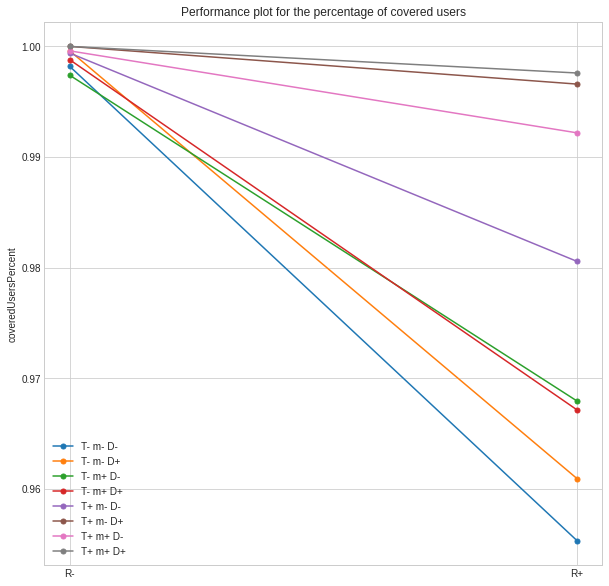

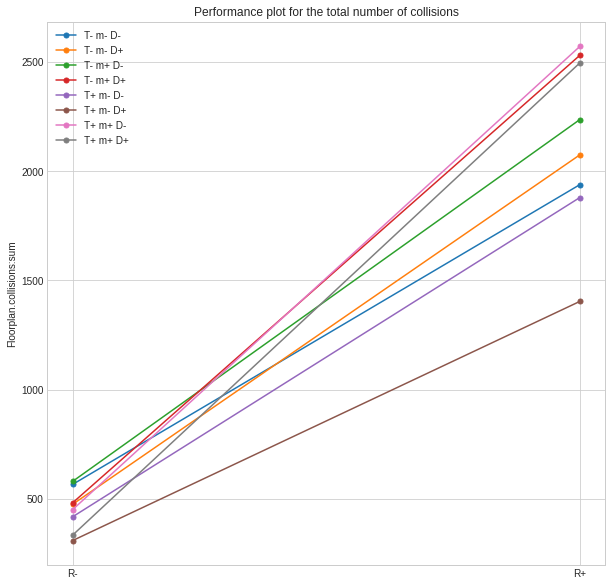

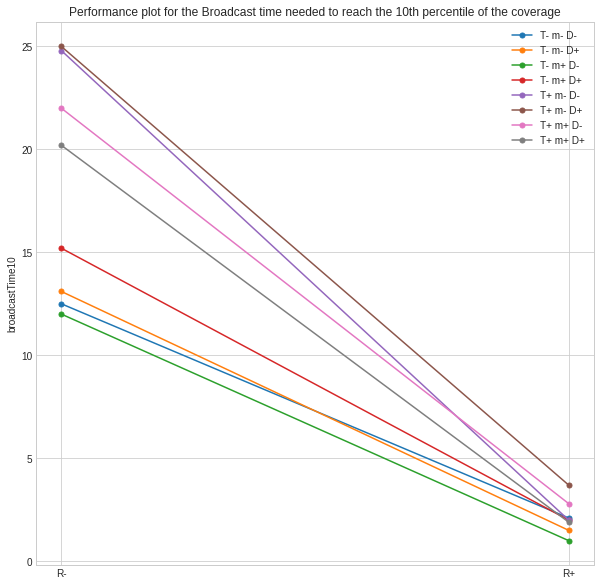

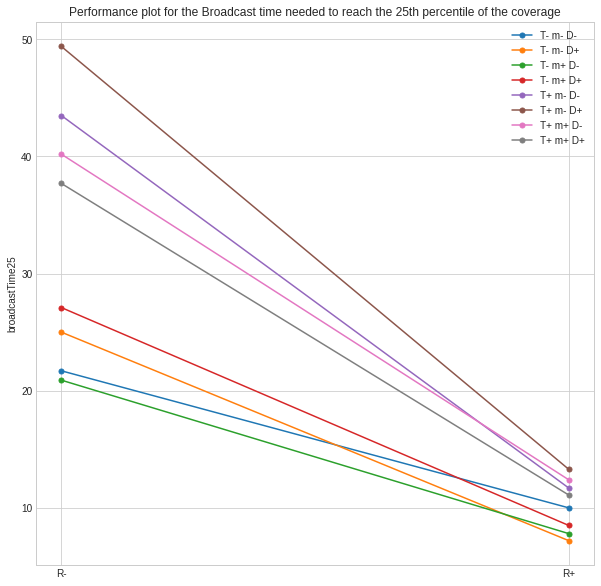

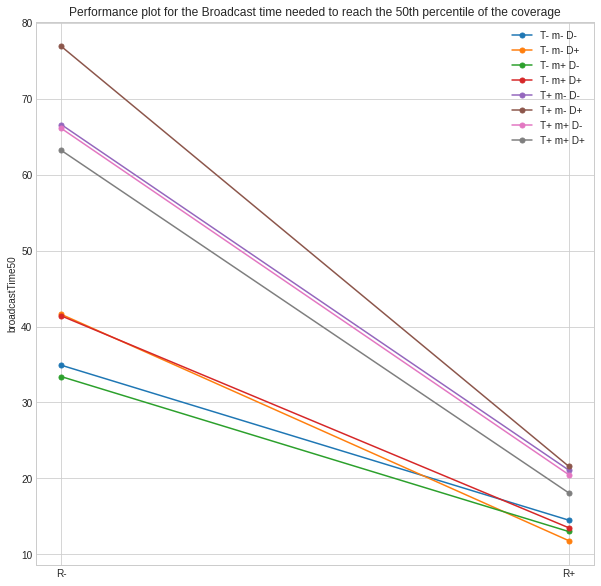

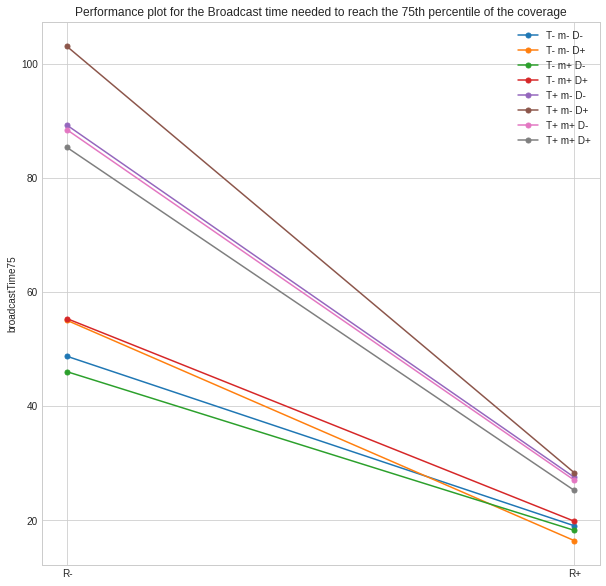

In [9]:
xarr = np.array([-1, 1])
idx = 0
for perfIndex, perfIndexDesc in perfIndexes:
    if perfIndex in skipped:
        continue
    ys = []
    es = []
    fs = []
    for cfg in range(0, configsCount):
        y = np.sum(factorsMatrix.loc[cfg, ['I'] + combinedFactors].values * computeMatrices[idx].loc['Mean (Qi)', ['I'] + combinedFactors].values)
        highy = np.sum(factorsMatrix.loc[cfg, combinedFactors].values * ciMatrices[idx].loc['CI+ Qi ({:.2%})'.format(tIntervalAlpha), combinedFactors].values)
        _, positiveInterval = tuple(v*math.sqrt(errorVariances[idx]/(configsCount*repetitionsCount)) for v in stats.t.interval(tIntervalAlpha, freedomDegrees))
        q0 = computeMatrices[idx].loc['Mean (Qi)']['I']
        highy += q0 + positiveInterval
        fs.append(' '.join([f + str('+' if factorsMatrix.loc[cfg][f] == 1 else '-') for f in factors[1:]]))
        ys.append(y)
        es.append(highy - y)

    plt.figure(figsize=plotSize)
    plt.style.use(plotStyle)
    plt.xticks(xarr, (factors[0] + '-', factors[0] + '+'))
    ys = [y for y in zip(ys[:configsCount//2], ys[configsCount//2:])]
    es = [e for e in zip(es[:configsCount//2], es[configsCount//2:])]
    for y, e, lbl in zip(ys, es, fs):
        yarr = np.array(y)
        earr = np.array(e)
        if plotErrorBars:
            plt.errorbar(x=xarr, y=yarr, yerr=earr, capsize=3, linestyle='-', marker='.', markersize=10, label=lbl)
        else:
            plt.plot(xarr, yarr, linestyle='-', marker='.', markersize=10, label=lbl)
    plt.title('Performance plot for the ' + perfIndexDesc)
    plt.ylabel(perfIndex)
    plt.legend()
    if saveFigures:
        fig = plt.gcf()
        fig.savefig('figures/' + get_file_name(varname) + '-perfplot.png')
    plt.show()
    idx += 1